## Load data

In [1]:
import numpy as np
import _pickle as pkl
import torch
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)
from argparse import Namespace
import json

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_len16_withGT_3D9E4376CF4746EEA20DCD520218038D.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vaughan/simple"),
 'device': 'cuda:0',
 'n_examples': 5,
 'n_pred': 10,
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

In [3]:
with open(args.dataset_path, 'rb') as f:
    raw_data = pkl.load(f)

data = {}
data['img_rgb'] = torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device)
data['img_gray'] = torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device)
data['haptic'] = torch.from_numpy(raw_data['ft']).float().to(device=args.device)
data['arm'] = torch.from_numpy(raw_data['arm']).float().to(device=args.device)

actions = torch.from_numpy(raw_data["action"]).to(device=args.device).float()

## Visualize

In [4]:
from utils import load_models, load_vh_models, frame_stack
import torch.nn as nn

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/simple/gru_contextnotindecoder_lm_ul_v_ctex-img
MSE of predictions:  [ 3.1225054  6.835666   8.374007  10.484827  15.21791   19.36034
 24.951601  35.577553  73.18761   88.15783  ]


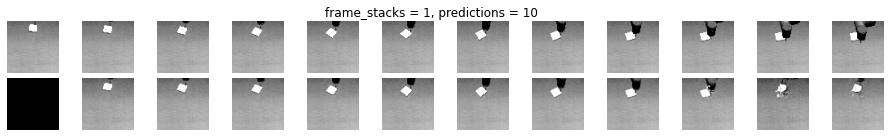

MSE of predictions:  [ 7.5102673  8.80326   13.814153  16.285257  20.239498  27.277416
 36.503456  44.1898    57.576355  81.63003  ]


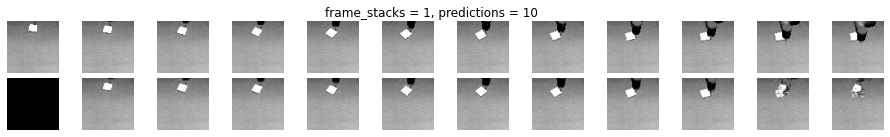

MSE of predictions:  [ 4.8341055  8.848421  10.643015  14.584933  19.074339  27.078432
 33.337284  40.218285  56.209866  85.84807  ]


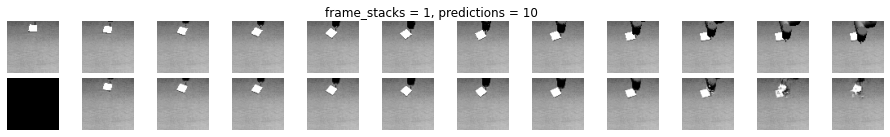

MSE of predictions:  [ 7.0816283  9.517077  11.905545  14.175364  20.667374  28.491833
 36.980797  46.34032   56.02461   86.27255  ]


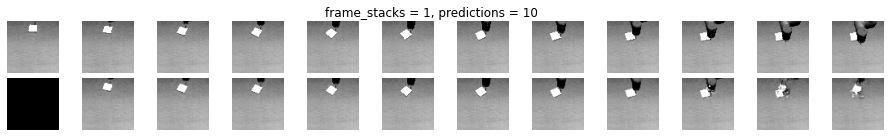

MSE of predictions:  [ 6.293637   9.578125  11.647289  15.1809635 23.211084  30.871712
 40.131435  43.064953  58.452126  87.01308  ]


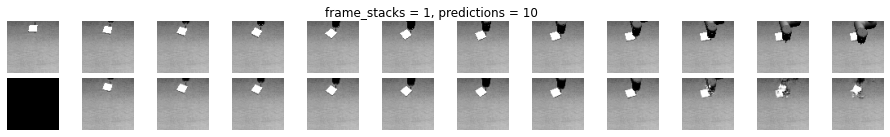

In [29]:
dict_of_models = load_models_dir(args.models_dir)

with torch.no_grad():
    for path, model_args in dict_of_models.items():

        #XXX: For testing
        if path != '/home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/simple/gru_contextnotindecoder_lm_ul_v_ctex-img':
            continue
        
#         if path != '/home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/simple/gru_contextnotindecoder_lm_ul_v':
#             continue
            
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)

        if model_args.dim_x[0] == 1:
            imgs = data['img_gray']
        elif model_args.dim_x[0] == 3:
            imgs = data['img_rgb']
        
        total_len = imgs.shape[1]
        T = model_args.frame_stacks
        
        ii = np.random.randint(imgs.shape[0] // args.n_examples)
        start_idx = 3
        
        x = imgs[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_pred)
        ]
        x_i = imgs[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1)
        ] 
        x_i = frame_stack(x_i, frames=T)[:, 0] 

        if model_args.use_context_img:
            ctx_img_i = x_i   
                    
        x_ft_i = data['haptic'][:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            T:(T + 1)
        ]
        x_arm_i = data['arm'][:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            T:(T + 1)
        ]

        u = actions[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            (T + 1):(T + 1 + args.n_pred)
        ] 
            
        # Roll-out or predictions
        if model_args.context_modality != "none":
            if model_args.context_modality == "joint": 
                ctx_i = torch.cat((x_ft_i, x_arm_i), dim=-1) # (n, l, f, 12)
            elif model_args.context_modality == "ft": 
                ctx_i = x_ft_i
            elif model_args.context_modality == "arm":
                ctx_i = x_arm_i
            ctx_i = ctx_i.float().to(device=args.device) # (n, l, f, 6)
            ctx_i = ctx_i.transpose(-1, -2)
            ctx_i = ctx_i.reshape(-1, *ctx_i.shape[2:])  

        # Encode
        z_all_enc = []

        z_img = nets["img_enc"](x_i)
        z_all_enc.append(z_img)              

        if model_args.context_modality != "none":
            z_context = nets["context_enc"](ctx_i)
            z_all_enc.append(z_context)
        if model_args.use_context_img:
            z_img_context = nets["context_img_enc"](ctx_img_i)
            z_all_enc.append(z_img_context)

        # Concatenate modalities and mix
        z_cat_enc = torch.cat(z_all_enc, dim=1)
        z_i, mu_z_i, logvar_z_i = nets["mix"](z_cat_enc)
        var_z_i = torch.diag_embed(torch.exp(logvar_z_i))
        h_i = None

        z_hat = torch.zeros((args.n_examples, (1 + args.n_pred), model_args.dim_z)).to(device=args.device)
        z_hat[:, 0] = z_i
        
        # Predict
        for jj in range(args.n_pred):
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                z_t=z_i, 
                mu_t=mu_z_i, 
                var_t=var_z_i, 
                u=u[:, jj], 
                h_0=h_i, 
                single=True
            )

            z_hat[:, jj + 1] = mu_z_ip1
            z_i, mu_z_i, var_z_i, h_i = z_ip1, mu_z_ip1, var_z_ip1, h_ip1    
                    
        # Decode
        z_all_dec = []
        z_all_dec.append(z_hat)
        if model_args.context_modality != "none":
            z_all_dec.append(z_context)
        if model_args.use_context_img:
            z_img_context_rep = z_img_context.unsqueeze(1).repeat(1, (args.n_pred + 1), 1)
            z_all_dec.append(z_img_context_rep)
        
        z_cat_dec = torch.cat(z_all_dec, dim=-1)
        
        x_hat = nets["img_dec"](z_cat_dec.reshape(-1, *z_cat_dec.shape[2:]))
        x_hat = x_hat.reshape(args.n_examples, (args.n_pred + 1), *x_hat.shape[1:])

        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x = x.cpu().numpy()
        mse = np.sum((x_hat[:, 1:, 1].reshape(args.n_examples, args.n_pred, -1) - 
                      x[:, 2:, 0].reshape(args.n_examples, args.n_pred, -1))**2, axis=2)

        # Plotting
        for bb in range(args.n_examples):
            columns = T + 1 + args.n_pred
            rows = 2
            fig=plt.figure(figsize=(16, 2))
            fig.suptitle('frame_stacks = {}, predictions = {}'.format(T, args.n_pred))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((model_args.dim_x[1], model_args.dim_x[2]))
                    else:
                        img = x_hat[bb,idx-1,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                
                plt.axis('off')
            print("MSE of predictions: ", mse[bb])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            plt.show()